# Titanic - Decision Tree

We will join Titanic challenge using Decision tree model.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")
from os.path import join
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# %matplotlib inline

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [2]:
input_dir = join("..", 'data', 'raw')
output_dir = join('..', 'data', 'result')
log_dir = join('..', 'log')
train = pd.read_csv(join(input_dir, 'train.csv'))
test = pd.read_csv(join(input_dir, 'test.csv'))

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


As we can see, there are so many things we have to deal with in order to clean the dataset in a way that machine could understand. We have cleaned Titanic dataset as well as create new features in the past experiments, we would love to apply that into this experiment.

In [3]:
# Get a copy of df_train and df_test dataset
df_train = train.copy()
df_test = test.copy()

# ===== Preprocessing =====
df_train = df_train.drop(['Ticket'], axis=1)
df_test = df_test.drop(['Ticket'], axis=1)

# Handle missing value for Age
master_train = df_train['Name'].str.contains(r',\s*Master.', regex=True)
df_master_train = df_train[master_train].copy()

master_test = df_test['Name'].str.contains(r',\s*Master.', regex=True)
df_master_test = df_test[master_test].copy()

median_age_train = df_train['Age'].median()
median_age_master_train = df_master_train['Age'].median()
median_age_test = df_test['Age'].median()
median_age_master_test = df_master_test['Age'].median()

df_master_train['Age'] = df_master_train['Age'].fillna(median_age_master_train)
df_train[master_train] = df_master_train
df_master_test['Age'] = df_master_test['Age'].fillna(median_age_master_test)
df_test[master_test] = df_master_test

df_train['Age'] = df_train['Age'].fillna(median_age_train)
df_test['Age'] = df_test['Age'].fillna(median_age_test)

# Handle missing value for Cabin, Embarked
df_train = df_train.drop(['Cabin'], axis=1)
df_test = df_test.drop(['Cabin'], axis=1)

df_train['Embarked'] = df_train['Embarked'].fillna("S")
df_test['Embarked'] = df_test['Embarked'].fillna("S")

fare_mean = df_train['Fare'].median()
df_test['Fare'] = df_test['Fare'].fillna(fare_mean)


# Feature encoding
df_train['Sex'] = df_train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
df_test['Sex'] = df_test['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
df_train['Embarked'] = df_train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
df_test['Embarked'] = df_test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# ===== Feature Engineering =====

# Familysize
df_train["FamilySize"] = df_train["SibSp"] + df_train["Parch"] + 1
df_test["FamilySize"] = df_test["SibSp"] + df_test["Parch"] + 1

df_train = df_train.drop(['Parch','SibSp'], axis=1)
df_test = df_test.drop(['Parch', 'SibSp'], axis=1)

# ageAndPclass
df_train["AgeAndPclass"] = df_train["Age"] * df_train["Pclass"]
df_test["AgeAndPclass"] = df_test["Age"] * df_test["Pclass"]

df_train = df_train.drop(['Age', 'Pclass', 'PassengerId'], axis=1)
df_test = df_test.drop(['Age', 'Pclass', 'PassengerId'], axis=1)

# Scale Fare feature using log transformation
df_train["FareTransformed"] = np.log10(df_train["Fare"] + 1)
df_test["FareTransformed"] = np.log10(df_test["Fare"] + 1)
df_train = df_train.drop(["Fare"], axis=1)
df_test = df_test.drop(["Fare"], axis=1)

df_train.head(3)

,Survived,Name,Sex,Embarked,FamilySize,AgeAndPclass,FareTransformed
0,0,"Braund, Mr. Owen Harris",1,0,2,66.0,0.916454
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,2,38.0,1.859038
2,1,"Heikkinen, Miss. Laina",0,0,1,78.0,0.950608


## `Title` feature

The dataset looks cleaner than the original. In our previous experiment, we did remove `Name` feature. However, as we saw interesting result from the experiment by Diego Milla (https://www.kaggle.com/code/dmilla/introduction-to-decision-trees-titanic-dataset), we decided to not remove `Name` feauture, and try to analyse it instead.

Now we will extract `Title` from `Name` feature like what Diego Milla did.

In [4]:
full_data = [df_train, df_test]
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

df_train = df_train.drop(['Name'], axis=1)
df_test = df_test.drop(['Name'], axis=1)
    
df_train.head(3)

,Survived,Sex,Embarked,FamilySize,AgeAndPclass,FareTransformed,Title
0,0,1,0,2,66.0,0.916454,1
1,1,0,1,2,38.0,1.859038,3
2,1,0,0,1,78.0,0.950608,4


<Axes: title={'center': 'Pearson Correlation of Features'}>

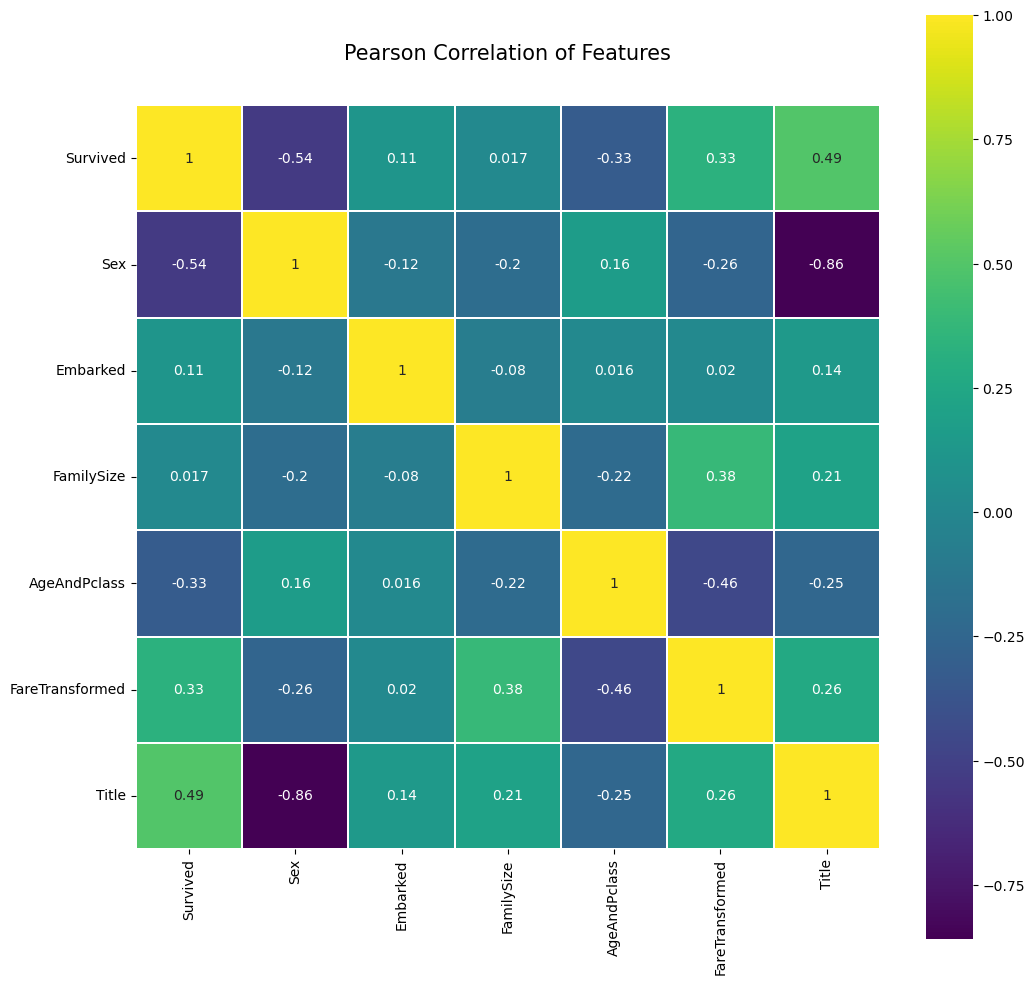

In [5]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

As we can see here, correlation between `Sex` and `Title` is quite high, it fact, it's the highest correlation figure in the heatmap. Which means that `Title` could contain some information of `Sex` or most of it. 

Base on Diego Milla's experiment, we can see that all of the titles share the same Sex, except for a single observation (a female with 'Dr' title). Therefore, `Title` may be more valuable to our task by capturing other characteristics of the individuals like age, social class, personality,...

## Gini impurity

We will check feature `Sex` and `Title` as a conditional point to see if the dataset could do the good job at splitting dataset by calculating Gini impurity for each feature.

In [6]:
# Define function to calculate Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

In [7]:
# Count number of passengers who did not survive (Survived == 0)
total_passenger = (df_train['Survived'] == 1).sum() + (df_train['Survived'] == 0).sum()
num_not_survived = (df_train['Survived'] == 0).sum()

# Male
total_male = (df_train['Sex'] == 1).sum()
total_male_survived = ((df_train['Sex'] == 1) & (df_train['Survived'] == 1)).sum()

# Female
total_female = total_passenger - total_male
total_female_survived = ((df_train['Sex'] == 0) & (df_train['Survived'] == 1)).sum()

# Title: title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
total_mr = (df_train['Title'] == 1).sum()
total_master = (df_train['Title'] == 2).sum()
total_mrs = (df_train['Title'] == 3).sum()
total_miss = (df_train['Title'] == 4).sum()
total_rare = (df_train['Title'] == 5).sum()

total_mr_survived = ((df_train['Title'] == 1) & (df_train['Survived'] == 1)).sum()
total_other_mr_survived = ((df_train['Title'] != 1) & (df_train['Survived'] == 1)).sum()

print("===== Split by Sex =====")
print(f"Total male survived: {total_male_survived}")
print(f"Total male not survived: {total_male - total_male_survived}\n")

print(f"Total female survived: {total_female_survived}")
print(f"Total female not survived: {total_female - total_female_survived}\n")

print("===== Split by Mr =====")
print(f"Total Mr survived: {total_mr_survived}")
print(f"Total Mr not survived: {total_mr - total_mr_survived}")
print(f'Total other than Mr survived: {total_other_mr_survived}')
print(f'Total other than Mr not survived: {total_passenger - total_mr - total_other_mr_survived}\n')

===== Split by Sex =====
Total male survived: 109
Total male not survived: 468

Total female survived: 233
Total female not survived: 81

===== Split by Mr =====
Total Mr survived: 81
Total Mr not survived: 436
Total other than Mr survived: 261
Total other than Mr not survived: 113



In [8]:
gini_baseline = get_gini_impurity(total_passenger - num_not_survived, total_passenger)
print(f'Gini Impurity of Titanic dataset if not split: {gini_baseline}')

Gini Impurity of Titanic dataset if not split: 0.47301295786144265


In [9]:
gini_male = get_gini_impurity(total_male_survived, total_male)
gini_male

np.float64(0.3064437162277843)

In [10]:
gini_female = get_gini_impurity(total_female_survived, total_female)
gini_female

np.float64(0.3828350034484158)

In [11]:
male_weight = total_male / total_passenger
female_weight = total_female / total_passenger
weight_gini_sex = male_weight * gini_male + female_weight * gini_female
print(f'Gini Impurity of Titanic dataset if split by Sex: {weight_gini_sex}')

Gini Impurity of Titanic dataset if split by Sex: 0.3333650003885905


In [12]:
gini_mr = get_gini_impurity(total_mr_survived, total_mr)
gini_mr

np.float64(0.26425329886377663)

In [13]:
gini_not_mr = get_gini_impurity(total_other_mr_survived, total_passenger - total_mr)
gini_not_mr

np.float64(0.42170207898424317)

In [14]:
mr_weight = total_mr / total_passenger
not_mr_weight = (total_passenger - total_mr) / total_passenger
weight_mr_gini = mr_weight * gini_mr + not_mr_weight * gini_not_mr
weight_mr_gini
print(f'Gini Impurity of Titanic dataset if split by Title (Mr): {weight_mr_gini}')

Gini Impurity of Titanic dataset if split by Title (Mr): 0.3303429102723675


From this df_test we could see that splitting tree using `Title` as the first conditional node would be better than `Sex` as Gini Impurity of title `Mr` is lower than that of `Sex`.

## Modelling

### Find the best depth for decision tree

In [15]:
cv = KFold(n_splits=10)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(df_test))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    # print("Current max depth: ", depth, "\n")
    for train_fold, valid_fold in cv.split(df_train):
        f_train = df_train.loc[train_fold] # Extract df_train data with cv indices
        f_valid = df_train.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold df_train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    # print("Accuracy per fold: ", fold_accuracy, "\n")
    # print("Average accuracy: ", avg)
    # print("\n")
    
# Just to show results conveniently
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.782285
         2          0.817066
         3          0.821548
         4          0.831660
         5          0.823883
         6          0.830562


### Create submission file

In [16]:
# Create Numpy arrays of df_train, df_test and target (Survived) dataframes to feed into our models
y_train = df_train['Survived']
x_train = df_train.drop(['Survived'], axis=1).values 
x_test = df_test.values

# Create Decision Tree with max_depth = 6
decision_tree = tree.DecisionTreeClassifier(max_depth = 6)
decision_tree.fit(x_train, y_train)

# Predicting results for df_test dataset
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": test['PassengerId'],
        "Survived": y_pred
    })
submission.to_csv(join(output_dir, 'submission.csv'), index=False)

joblib.dump(decision_tree, join('..', 'log', 'decision_tree_model.pkl'))

['..\\log\\decision_tree_model.pkl']

In [17]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

86.64

# The end